# Encoder-Decoder 모델 개요

Encoder-Decoder 구조는 입력 데이터를 고정된 크기의 벡터 표현으로 변환(인코딩)하고, 이를 다시 원하는 형태로 변환(디코딩)하는 구조.

Encoder-Decoder 모델은 입력 도메인에서 출력 도메인으로 데이터 포인트를 매핑하는 것을 학습하는 모델군으로, 두 단계의 네트워크로 구성된다.

- 인코더(Encoder): 입력 시퀀스 $x$를 고정된 크기의 벡터 $z = f(x)$로 인코딩하여 의미 정보를 압축한다.
  
- 디코더(Decoder): 이 잠재 벡터 $z$를 바탕으로 출력 시퀀스 $y = g(z)$를 단계적으로 생성한다.

이때, $f$와 $g$는 각각 딥러닝 기반의 함수 (예: RNN, LSTM, GRU, Transformer 등)로 구현된다.

이 구조는 주로 자연어 처리에서 많이 사용되며, 기계 번역, 요약, 대화 시스템 등 다양한 곳에서 응용 된다. 곳에서 응용 된다.


## Encoder

* **입력 시퀀스** \$\mathbf{x} = (x\_1, x\_2, \dots, x\_T)\$를 고정된 크기의 벡터(또는 상태 벡터)로 인코딩한다.
  
* 일반적으로 **순환 신경망(RNN, LSTM, GRU)** 또는 **Transformer 인코더**가 사용된다.

* 인코딩 결과로 생성된 **최종 은닉 상태(hidden state)** 또는 **모든 시점의 은닉 상태의 조합**이 디코더에 입력되는 **컨텍스트 벡터(context vector)**가 된다.

* 설명 단순화를 위해, 아래 예제에서는 Dense Layer 등을 활용한 간단한 인코딩 구조를 사용하기도 한다.


## Decoder

* 인코더에서 전달된 컨텍스트 벡터(또는 시계열 상태)를 기반으로 **출력 시퀀스** \$\mathbf{y} = (y\_1, y\_2, \dots, y\_{T'})\$를 단계적으로 생성한다.

* 초기 상태는 컨텍스트 벡터로 설정되며, 이후 이전 출력 결과를 입력으로 사용해 다음 출력을 예측하는 **autoregressive 구조**를 가진다.

* 디코더에서도 주로 **RNN 계열** 또는 **Transformer 디코더**가 사용되며, Attention 메커니즘이 함께 사용되면 인코더의 전체 시퀀스를 동적으로 참조할 수 있다.


## Autoencoder

입력과 출력이 동일한 인코더-디코더 모델의 특수한 사례를 **Autoencoder**라고 부른다.

오토인코더는 입력 데이터를 저차원의 **잠재 공간(latent space)** 으로 압축한 뒤, 이를 다시 원래의 입력과 최대한 유사하게 복원하도록 학습하는 **비지도 학습 모델**이다.

기본적인 구조는 일반적인 Encoder-Decoder와 유사하나, **입력과 출력이 동일**하다는 점에서 차별된다. 
- 즉, 모델은 입력 데이터를 스스로 "설명"하는 방식으로 내부 표현을 학습한다.

오토인코더는 다음 두 구성 요소로 이루어진다:

* **인코더(Encoder)**: 입력 데이터를 잠재 벡터 \$z\$로 압축하는 함수 \$z = f(x)\$
  
* **디코더(Decoder)**: 잠재 벡터 \$z\$를 다시 원래의 입력으로 복원하는 함수 \$\hat{x} = g(z)\$

학습의 목적은 **복원된 출력 \$\hat{x}\$가 원래 입력 \$x\$와 최대한 비슷해지도록** 손실함수(예: MSE)를 최소화하는 것이다.

이러한 구조는 다음과 같은 다양한 응용으로 활용된다:

* 차원 축소 (PCA의 비선형 확장으로 이해 가능)
* 노이즈 제거 (Denoising Autoencoder)
* 이상 탐지 (입력과 출력 차이가 큰 데이터를 이상으로 탐지)
* 데이터 생성 (변형된 오토인코더: Variational Autoencoder 등)

### Autoencoder MINST 예제

다음은 Autoencoder를 사용하는 예제이다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import fashion_mnist

# Fashion MNIST 데이터 로드
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))   # np.prod(x_train.shape[1:]) : 28 * 28 =  784
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

`encoding_dim`은 인코더에서 사용할 dense layer의 유닛의 수로, 이것을 32로 설정하여 784의 `input_dim`보다 훨씬 작은 차원을 구성하였다.

이것은 autoencoder가 때로는 입력된 데이터를 요약하는 역할을 할 수 있음을 뜻한다.

In [2]:
# Autoencoder 모델 구성
input_dim = x_train.shape[1]
encoding_dim = 32  # 잠재 공간 크기

간단하게 인코더와 디코더를 구성하고, 이 둘을 이용하여 `autoencoder` 모형을 정의하였다.

In [3]:
autoencoder = Sequential(name='autoencoder_model')

# 인코더 부분
autoencoder.add(Dense(encoding_dim, activation='relu', input_shape=(input_dim,), name='encoded_layer'))

# 디코더 부분
autoencoder.add(Dense(input_dim, activation='sigmoid', name='decoded_layer'))

# 모델 요약 출력
autoencoder.summary()

Model: "autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoded_layer (Dense)       (None, 32)                25120     
                                                                 
 decoded_layer (Dense)       (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


이 모형의 구조는 다음과 같다.

```
Input (784) → [Encoder Layer] → Encoded (32) → [Decoder Layer] → Output (784)

```

실제로 이 autoencoder 모형은 매우 간단하여 앞에서 공부했던 MLP의 구조와 흡사하다. 

데이터의 흐름을 보면, 처음에 784개의 차원을 가진 데이터가 32개의 차의 잠재 표현으로로 압축되었다가, 다시 784개의 차원으로 확장되는 과정을 거친다.

이처럼 Autoencoder는 입력 데이터를 낮은 차원으로 압축하는 기능이 있다.
 
- 이는 데이터의 중요한 특징만을 추출하여 저장할 수 있게 하며, 차원 축소 기법의 하나로 활용된다.

- 이로 인해 데이터 저장 공간이 줄어들고, 계산 효율성이 높아질 수 있다.

- 예를 들어, 이미지 데이터의 경우 이미지의 중요한 특징만을 저장하여 메모리 사용을 줄일 수 있다.

In [4]:
# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 모델 학습
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
235/235 [==============================] - 4s 11ms/step - loss: 0.4156 - val_loss: 0.3431
Epoch 2/20
235/235 [==============================] - 2s 9ms/step - loss: 0.3282 - val_loss: 0.3203
Epoch 3/20
235/235 [==============================] - 2s 9ms/step - loss: 0.3124 - val_loss: 0.3092
Epoch 4/20
235/235 [==============================] - 2s 9ms/step - loss: 0.3026 - val_loss: 0.3005
Epoch 5/20
235/235 [==============================] - 2s 9ms/step - loss: 0.2957 - val_loss: 0.2954
Epoch 6/20
235/235 [==============================] - 2s 9ms/step - loss: 0.2917 - val_loss: 0.2925
Epoch 7/20
235/235 [==============================] - 2s 9ms/step - loss: 0.2892 - val_loss: 0.2906
Epoch 8/20
235/235 [==============================] - 2s 9ms/step - loss: 0.2876 - val_loss: 0.2892
Epoch 9/20
235/235 [==============================] - 2s 9ms/step - loss: 0.2866 - val_loss: 0.2883
Epoch 10/20
235/235 [==============================] - 2s 9ms/step - loss: 0.2858 - val_loss: 0.287

### 예측 및 노이즈 복원

그림에 인위적으로 노이즈를 추가한 후 복원하는 작업을 하여 보겠다.


Autoencoder는 입력 데이터를 재구성하면서 노이즈를 제거하는 능력이 있다. 

- 노이즈가 있는 데이터를 입력으로 주었을 때, 모델은 노이즈 없는 깨끗한 데이터를 출력하려고 시도한다. 
- 이미지 복원, 음성 신호 처리 등에서 유용하게 사용된다.

먼저 노이즈를 인위적으로 그림에 추가해 본다.

In [5]:
# 노이즈 추가
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# np.clip는 값을 0 과 1 사이로 제한
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [6]:
# 노이즈 데이터 복원
decoded_imgs = autoencoder.predict(x_test_noisy)

313/313 [==============================] - 1s 2ms/step


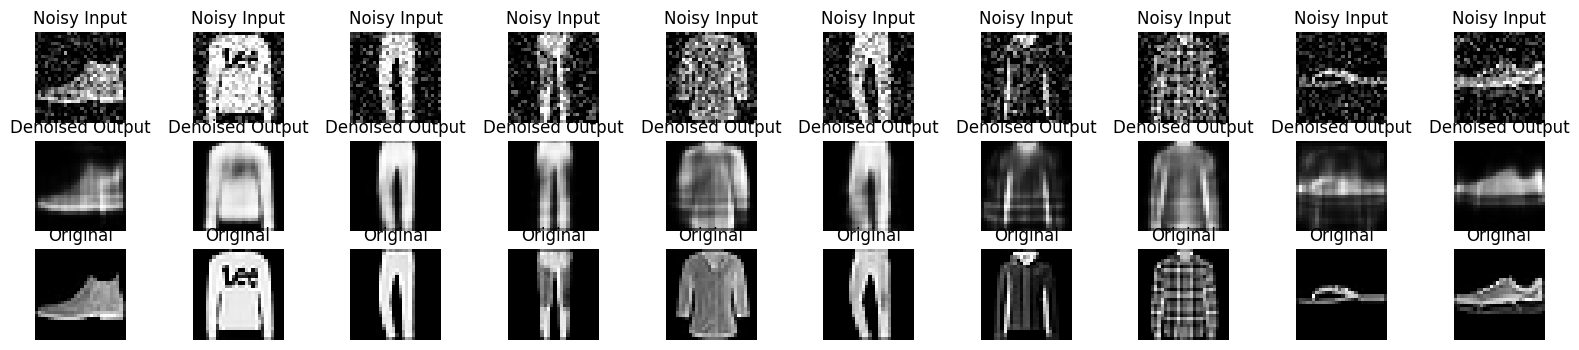

In [7]:
# 결과 시각화
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 노이즈 입력 이미지
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy Input")
    plt.axis('off')

    # 복원된 이미지
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised Output")
    plt.axis('off')

    # 원본 이미지
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.show()

## seq2seq를 수행하는 Encoder-Decoder 예제 1

이 예제에서는 매우 간단한 seq2seq를 수행하는 Encoder-Decoder 구조를 구현한다.

- seq2seq는 입력 시퀀스를 받아 출력 시퀀스를 내는 딥러닝 아키텍처를 총칭하며, 보통 인코더-디코더의 구조로 되어있다.

먼저 오토인코더에서처럼 입력과 출력이 같은 모형을 만들어 보자. 다만 위의 fashion MNIST 예제보다는 조금 더 복잡한 구조이니 주의깊게 살펴보자.

- 입력 : 5개의 연속으로 된 숫자 배열
  
- 출력 : 동일한 숫자 배열

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

# 시퀀스의 길이는 timesteps로 정의됨
timesteps = 5

아래 모델 parameter에서 `latent_dim`은 앞으로 정의할 인코더의 LSTM 유닛의 수를 의미한다.

- LSTM에서 유닛의 수 = 출력의 수 = 은닉 상태의 수 = 셀 상태의 수

- 일반적으로 차원이 축소되는 오토인코더와는 달리, 이 예제는 충분히 많은 LSTM의 유닛의 수로 통해 입력 시퀀스의 특성을 잡아내는 것이 목표이다.

In [9]:
input_dim = 1
latent_dim = 50

### 인코더 

아래 코드에서 [`Input`](https://www.tensorflow.org/api_docs/python/tf/keras/Input)과 [`LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer들을 이용하여 **인코더**를 먼저 정의한다.

`LSTM`에서 `return_state=True`로 설정하면, 마지막 최종 은닉 상태(h)와 최종 셀 상태(c)를 같이 반환한다.

- 은닉 상태 : 단기 메모리
- 셀 상태 : 장기 메모리

이 두 상태 벡터는 **컨텍스트 벡터**라고도 하며, 입력 시퀀스의 중요한 특징을 압축해 담고 있는 표현이라 할 수 있다.

한편, 아래에서 인코더를 정의할 때, 지금까지 사용했던 [Sequential API](https://keras.io/guides/sequential_model/)를 사용하지 않고 [Functional API](https://keras.io/guides/functional_api/)를 사용하여 정의하고 있다.

이 방법은 복잡한 모델 구조를 설정할 때 유용하다.

* **Sequential API**는 층(layer)을 순차적으로 쌓아 올리는 구조에 적합하다.
  
* 반면, **Functional API**는 입력과 출력을 명시적으로 연결하여 모델을 구성하기 때문에,

  * **복잡한 네트워크 구조** (예: 여러 입력/출력, 분기, 병합 등)를 자유롭게 설계할 수 있다.

  * Encoder-Decoder 같은 **다중 입출력 구조** 구현에 매우 유용하다.

Functional API에서는 다음과 같이 구성한다:

1. `Input()`으로 입력 텐서를 정의한다.
2. 입력 텐서를 원하는 레이어에 통과시켜 출력을 생성한다.
3. `Model(inputs=..., outputs=...)`를 통해 입력과 출력을 연결하여 모델을 생성한다.


In [10]:
encoder_inputs = Input(shape=(timesteps, input_dim), name='encoder_input')
encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

이들은 Tesor 객체들이며, Functional API에서 모델의 입력과 출력을 정의할 때 사용한다.

In [11]:
type(encoder_inputs), type(encoder_outputs), type(state_h), type(state_c)

(keras.engine.keras_tensor.KerasTensor,
 keras.engine.keras_tensor.KerasTensor,
 keras.engine.keras_tensor.KerasTensor,
 keras.engine.keras_tensor.KerasTensor)

### 디코더

아래에서 **디코더**를 정의한다.

* 디코더도 인코더와 마찬가지로 `Input`과 `LSTM` 레이어로 구성되며, 마지막에는 출력 차원에 맞는 `Dense` 레이어가 최종 출력을 담당한다.

* 인코더에서 반환된 **은닉 상태** (`state_h`)와 **셀 상태** (`state_c`)를 디코더의 `LSTM`에서 `initial_state` 인자로 사용해 디코더의 초기 메모리를 설정한다.

* 이렇게 초기화된 상태 벡터들은 원본 입력 시퀀스에 대한 압축된 정보를 담고 있다고 볼 수 있다.

### `encoder_outputs`와 디코더의 관계

* 일반적으로, 인코더의 마지막 LSTM이 `return_sequences=True`로 설정되면, **모든 타임스텝에 대한 출력**인 `encoder_outputs`가 반환된다.

* 이 `encoder_outputs`는 디코더로 전달될 수도 있고, 그렇지 않을 수도 있다.

* 이 예제에서는 `encoder_outputs`를 디코더에 직접 전달하지 않고, 상태 벡터들인 `state_h`, `state_c`만 디코더로 전달한다.

* 반면, **Attention 메커니즘**을 사용하는 경우에는 `encoder_outputs`가 필수적으로 디코더에 전달되어, 디코더가 시점마다 인코더의 전체 출력 시퀀스를 동적으로 참조할 수 있다.

* 따라서 `encoder_outputs`의 전달 여부는 모델 구조와 목적에 따라 다르며, 이 예제는 Attention 없이 간단한 인코더-디코더 구조임을 참고하면 된다.

In [12]:
# 디코더 정의
decoder_inputs = Input(shape=(timesteps, input_dim), name='decoder_input')
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
decoder_dense = Dense(input_dim, activation='linear', name='decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

### 모델

이제 모델을 정의한다.

아래 코드에서 `Model`을 정의할 때, `inputs` 인자에 `[encoder_inputs, decoder_inputs]`처럼 **입력 텐서 리스트**를 사용하였다.

- `Model`의 inputs 인자로 리스트를 사용함으로써, 모델이 여러 입력을 동시에 받을 수 있도록 한다. 

- 인코더-디코더 구조에서는 인코더와 디코더가 각각 별도의 입력을 필요하기 때문이다.

   - Functional API를 사용해야 하는 이유이다. <br><br>

#### Functional API와 모델 구성

* Sequential API는 단일 입력-출력 구조를 순차적으로 쌓는 데 최적화되어 있다.
  
* 반면, Functional API는 **복잡한 네트워크 구조**를 자유롭게 설계할 수 있다.
  (여러 입력, 여러 출력, 분기, 병합 등)

* Functional API에서 모델은 `Model(inputs=..., outputs=...)` 형태로 생성하며,
  `inputs`는 입력 텐서(들), `outputs`는 최종 출력 텐서(들)를 의미한다.

* 여기서 인코더 입력과 디코더 입력 텐서는 이미 앞서 정의한 인코더, 디코더 부분의 입출력 흐름에 맞게 연결되어 있다.


In [13]:
# 모델 정의
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = decoder_outputs)

이 모델은 다음의 데이터 흐름을 가진다.
```
encoder_input → [Encoder LSTM] → state_h, state_c
                                     ↓  
decoder_input → [Decoder LSTM] (uses state_h, state_c) → decoder_output → [Dense] → Final output
```

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 5, 1)]       0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, 5, 1)]       0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 50),         10400       ['encoder_input[0][0]']          
                                 (None, 50),                                                      
                                 (None, 50)]                                                      
                                                                                              

In [15]:
model.compile(optimizer='adam', loss='mse')

### 훈련

훈련에 사용할 간단한 시퀀스 데이터 생성하자.

이 랜덤 시퀀스는 첫 시작점만 랜덤이고, 그 이후의 값은 1씩 증가

In [16]:
start_points = np.random.uniform(0, 100, size=1000)

# 각 시작점에서 timesteps만큼 연속된 실수 생성
input_data = np.array([start + np.arange(timesteps) for start in start_points])

# 데이터 전처리
input_data = input_data[:, :, np.newaxis]  # (1000, 5, 1)

이 간단한 예제에서는 `target_data = input_data`이다.

- 디코더의 input으로 `target_data`를 그대로 사용하였다.
  
- `x`는 `[input_data, target_data]`로 리스트로 구성되어 있으며 모델이 다중 입력을 받기 때문.

- `input_data`는 인코더, `target_data`는 디코더에 대한 입력이다.

- 즉, 이 예제에서는 훈련에서 인코더 입력 = 디코더 입력 = 모델 출력이다.

이 모형은 연속된 숫자들, 예를 들어 `[4, 5, 6, 7, 8]`을 입력받았을 때, 입력값과 동일한 `[4, 5, 6, 7, 8]`을 출력하도록 하는 것이 목표이다.

- 실용적 관점에서는 의미가 없지만, encoder-decoder를 구현하는 연습 예제

In [17]:
target_data = input_data 
model.fit(x=[input_data, target_data], y=target_data, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 7s 11ms/step - loss: 3567.1135
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 3282.7788
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 2828.1792
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 2517.4048
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 2330.1267
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 2183.6165
Epoch 7/50
32/32 [==============================] - 0s 10ms/step - loss: 2048.2769
Epoch 8/50
32/32 [==============================] - 0s 10ms/step - loss: 1914.7219
Epoch 9/50
32/32 [==============================] - 0s 11ms/step - loss: 1781.8304
Epoch 10/50
32/32 [==============================] - 0s 10ms/step - loss: 1672.3877
Epoch 11/50
32/32 [==============================] - 0s 10ms/step - loss: 1578.5138
Epoch 12/50
32/32 [==============================] - 0s 11ms/step - loss: 1491.6135
E

### 테스트

간단히 테스트 해 보자.

`model.predict`를 할 때, 디코더의 input으로 encoder의 input을 그대로 입력하여 활용하였으나, 일반적인 seq2seq 모형에서는 보다 정교하게 수정하여 사용해야 한다.

- `model.predict([new_input_data, new_input_data])`

  - 정확한 디코딩 방식은 아니며, 훈련 시와 동일한 구조 (`[encoder_input, decoder_input]`)를 만족시키기 위해 임시로 decoder_input에도 같은 값을 넣은 것

  - 디코더 입력은 원래는 정답 시퀀스를 왼쪽으로 시프트한 값 + 시작 토큰이 되어야 함

  - 해당 사항은 다음 예제에서 살펴보겠다.

In [18]:
# 새로운 입력 데이터 생성
new_input_data = np.array([4, 5, 6, 7, 8])  # 새로운 시퀀스
new_input_data = new_input_data[np.newaxis, :,  np.newaxis]
# 예측 수행
predicted_output = model.predict([new_input_data, new_input_data])
predicted_output = np.squeeze(predicted_output)  # 불필요한 차원 제거

print("입력 시퀀스:", np.squeeze(new_input_data))
print("예측된 출력 시퀀스:", predicted_output)

1/1 [==============================] - 2s 2s/step
입력 시퀀스: [4 5 6 7 8]
예측된 출력 시퀀스: [4.0303726 5.0121365 6.0659165 6.990729  8.034168 ]


## seq2seq를 수행하는 Encoder-Decoder 예제 2

이 예제에서는 위 예제를 업그레이드하여 간단한 seq2seq를 수행하는 Encoder-Decoder 구조를 구현한다.

이번에는 연속된 숫자를 입력으로 받아 출력이 입력 +1 이 되게 생성되도록 하는 것이 목표이다.

- 인코더 입력 : `[4, 5, 6, 7, 8]` -> 디코더 출력 : `[5, 6, 7, 8, 9]`

In [19]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# 시퀀스의 길이
timesteps = 5

# 모델 파라미터
input_dim = 1   # 1-dim 시계열임을 의미
latent_dim = 50

인코더와 디코더, 그리고 전체 모델은 위 예제와 거의 동일하게 정의하였다.

### 인코더

In [20]:
# 인코더 정의
encoder_inputs = Input(shape=(timesteps, input_dim), name='encoder_input')
encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

### 훈련용 디코더

디코더는 Input, LSTM과 Dense 층으로 구성된다. 

Input 층은 다음과 같다.

- `Input(shape=(timesteps + 1, input_dim), name='decoder_input')`  

디코더 입력이 `Input(shape=(timesteps + 1, input_dim))`인 이유는, 추후에 **특수 토큰(special token)** 을 포함시키기 위함.

* 예: 시작 토큰 또는 종료 토큰  

* 기본적으로 디코더는 입력 시퀀스 길이(`timesteps`)와 동일한 시퀀스를 출력해야 하지만,
  시작 토큰을 추가하여 디코딩을 보다 명확하게 제어할 수 있도록 길이를 하나 더 늘려놓았다.

* 길이가 `timesteps + 1`인 시퀀스가 다음의 순환 신경망(`LSTM`)에 순차적으로 입력된다.
  
LSTM 층은 다음과 같다.

- `LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')`

`decoder_lstm`은 시퀀스의 모든 타임스텝에 대해 출력을 내며 (`return_sequences=True`),
  마지막 시점의 은닉 상태와 셀 상태도 함께 반환(`return_state=True`).

* 이 상태들은 훈련에서는 쓰이지 않고, 예측 과정에서 활용될 예정임

* `decoder_lstm`의 output인 `decoder_outputs`는 `(batch_size, timesteps = 5, latent_dim = 50)`의 출력 shape을 가짐

`decoder_dense`는 LSTM의 출력 차원을 입력 차원(`input_dim = 1`)으로 변환하는 역할을 하며, 활성화는 연속 값을 다루도록 선형(`linear`) 함수 사용.

- `Dense(input_dim, activation='linear', name='decoder_output')`

- `decoder_dense`는 `(batch_size, timesteps = 5, latent_dim = 50)`의 입력을 받아 `(batch_size, timesteps = 5, input_dim = 1)`의 출력을 내보냄

- Keras의 `Dense` 레이어는 3-dim 입력 `(batch_size, time_steps, features)`를 받을 경우 TimeDistributed 방식으로 작동하기 때문

In [21]:
# 디코더 정의
decoder_inputs = Input(shape=(timesteps + 1, input_dim), name='decoder_input')  

# layer 정의
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
# layer의 입출력 tensor 설정
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

# Layer 정의
decoder_dense = Dense(input_dim, activation='linear', name='decoder_output')
# layer의 입출력 tensor 설정
decoder_outputs = decoder_dense(decoder_outputs)

In [22]:
# 전체 모델 정의
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = decoder_outputs)
model.summary()
# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 5, 1)]       0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, 6, 1)]       0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 50),         10400       ['encoder_input[0][0]']          
                                 (None, 50),                                                      
                                 (None, 50)]                                                      
                                                                                            

인코더의 input에 활용할 `input_data`는 앞의 예제와 동일한 방법으로 생성하였다.

디코더의 target으로 활용할 `output_data`는 `input_data`에 1을 더한 형태.

In [23]:
# 훈련에 사용할 간단한 시퀀스 데이터 생성
# 이 랜덤 시퀀스는 첫 시작점만 랜덤이고, 그 이후의 값은 1씩 증가
start_points = np.random.uniform(0, 100, size=1000)
input_data = np.array([start + np.arange(timesteps) for start in start_points])

# 데이터 전처리
input_data = input_data[:, :, np.newaxis]  # (1000, 5, 1)
output_data = input_data + 1  # 출력은 입력값에 1을 더한 시퀀스

### 디코더 입력 구성

이제 훈련에 필요한 **디코더의 입력**을 정해 주자.

특수 시작 토큰:
  
- 디코더 입력의 시작 부분에는 보통 특수한 시작 토큰(start token)을 정의하여 시퀀스 예측의 시작을 알린다.  

- 이 예제에서는 편의를 위해 `0`을 시작 토큰으로 사용하였다.

- 마찬가지로 끝 부분에도 특수 종료 토큰을 사용할 수 있다.

보통 인코더-디코더 구조에서는 **훈련 단계**와 **예측(추론) 단계**에서 디코더의 입력이 다르게 설정된다

- 훈련 시엔 Teacher Forcing

- 예측 시엔 step-by-step decoding

#### 훈련 단계

디코더는 훈련 단계에서 **타깃 시퀀스의 처음부터 끝까지 전체를 입력으로 받는다.**

예를 들어, 인코더 입력이 `[1, 2, 3, 4, 5]`일 때, 디코더 출력으로 `[2, 3, 4, 5, 6]`을 해야하는 상황을 고려하자.

훈련 시에 디코더 입력으로, `[0, 2, 3, 4, 5, 6]` **정답 시퀀스**를 한 칸씩 뒤로 이동한 형태가 주어진다.

* 정답 시퀀스를 그대로 이용하는 방식을 **Teacher Forcing**이라고 부른다.

  * 디코더의 예측이 `2, 3, 4, 5, 6`으로 정확하게 이루어졌다고 가정하는 것.<br><br>

* Teacher Forcing은 모델이 실제 출력과 목표 출력(target) 간의 차이를 빠르게 학습할 수 있게 도와주어,
  훈련 속도를 높이고 수렴을 가속화하는 효과가 있다.

#### 예측 단계와의 차이

실제 예측은 **step-by-step**으로 이루어지며, 각 스텝의 예측은 어느 정도 오차가 발생할 수 있다는 점이 다르다.

훈련 시에는 이전 단계의 정답 시퀀스를 입력으로 받지만, 실제 예측 단계에서는 모델이 스스로 생성한 이전 출력에 의존해야 하기 때문이다.

예를 들어, 다음과 같은 예측 과정 시나리오를 생각해 보면, 매 출력의 예측이 항상 정답과 완벽하게 일치하지는 않을 수 있음을 충분히 상상할 수 있다.

* 1을 보고 2를 예측해야 함, 가상의 예측 과정 : 1 → 2.01
* 2를 보고 3을 예측해야 함, 가상의 예측 과정 : 2.01 → 3.02
* 3을 보고 4를 예측해야 함, 가상의 예측 과정 : 3.02 → 4.04
* 4를 보고 5를 예측해야 함, 가상의 예측 과정 : 4.04 → 5.03
* 5를 보고 6을 예측해야 함, 가상의 예측 과정 : 5.03 → 6.03

반면, 훈련 과정에서는 디코더 입력으로 `[0, 2, 3, 4, 5, 6]`의 정답값을 순차적으로 이용하여 다음 출력을 예측하는 훈련을 하는 것이다. 

즉, Teacher forcing 방법은 예측 과정에서 디코더 출력이 정확할 것이라고 가정하는 것과 같음

- 이에, Teacher Forcing은 훈련과 예측 간 불일치 문제(exposure bias)가 발생할 수 있다고 알려져 있음

예측 단계의 디코더 입력은 추후에 설명한다.


In [24]:
# 시작 토큰 추가 및 디코더 입력 생성
start_token = np.zeros((input_data.shape[0], 1, 1))
decoder_input_data_with_start_token = np.concatenate([start_token, output_data[:, :, :]], axis=1)
end_token = np.zeros((output_data.shape[0], 1, 1))
output_data_with_end_token = np.concatenate([output_data, end_token], axis=1)

print("Encoder input data  : ", np.squeeze(input_data[0, :, :]))
print("Decoder input data  : ", np.squeeze(decoder_input_data_with_start_token[0, :, :]))
print("Target data         : ", np.squeeze(output_data_with_end_token[0, :, :]))

Encoder input data  :  [12.70086445 13.70086445 14.70086445 15.70086445 16.70086445]
Decoder input data  :  [ 0.         13.70086445 14.70086445 15.70086445 16.70086445 17.70086445]
Target data         :  [13.70086445 14.70086445 15.70086445 16.70086445 17.70086445  0.        ]


In [25]:
# 모델 훈련
model.fit([input_data, decoder_input_data_with_start_token], output_data_with_end_token, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 8s 12ms/step - loss: 2782.6846
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 2518.6484
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 2239.0066
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 2032.3350
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 1894.6049
Epoch 6/100
32/32 [==============================] - 0s 12ms/step - loss: 1751.7755
Epoch 7/100
32/32 [==============================] - 0s 10ms/step - loss: 1638.4122
Epoch 8/100
32/32 [==============================] - 0s 12ms/step - loss: 1525.0463
Epoch 9/100
32/32 [==============================] - 0s 11ms/step - loss: 1434.2130
Epoch 10/100
32/32 [==============================] - 0s 10ms/step - loss: 1354.0419
Epoch 11/100
32/32 [==============================] - 0s 11ms/step - loss: 1279.7094
Epoch 12/100
32/32 [==============================] - 0s 11ms/step - loss:

### 예측(추론)

Seq2Seq 모델에서는 훈련 단계와 예측 단계의 동작이 다르기 때문에, 예측 단계에서는 인코더와 디코더를 별도로 정의하여 사용해야 한다. 

- 훈련 단계에서는 정답 시퀀스를 한 번에 디코더에 넣는 Teacher Forcing을 사용하지만,

- 예측 단계에서는 이전 시점의 출력값을 다음 입력으로 반복적으로 사용하는 방식이기 때문이다

이를 위해, 훈련이 완료된 모델로부터 인코더와 디코더 모델을 각각 추출하여 별도로 정의한다.

예측을 위한 인코더 모델과 디코더 모델의 역할은 다음과 같다.

#### 예측용 인코더 모델

훈련 때와는 달리 인코더 모델을 따로 생성한다. 예측 시 디코더에서 한 스텝씩 반복 처리해야 하기 때문.

별도로 생성된 인코더 모델이 출력하는 값들을 디코더로 전달할 계획

- 인코더는 훈련이 종료된 인코더 네트워크를 이용하여 동일하게 구성하며, 입력 시퀀스를 받아 마지막 시점의 **은닉 상태(state_h)** 와 **셀 상태(state_c)** 를 출력한다.

- 이 상태 벡터들이 디코더의 **초기 상태(initial state)** 로 사용된다.

- 예측 과정에서 인코더는 입력 시퀀스를 잠재 표현으로 인코딩해주는 역할을 하며, 한 번만 호출된다.

In [26]:
# 인코더 모델 정의 (예측 시에 필요)
encoder_model = Model(inputs = encoder_inputs, outputs = [state_h, state_c])
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 5, 1)]            0         
                                                                 
 encoder_lstm (LSTM)         [(None, 50),              10400     
                              (None, 50),                        
                              (None, 50)]                        
                                                                 
Total params: 10,400
Trainable params: 10,400
Non-trainable params: 0
_________________________________________________________________


####  예측용 디코더 모델

* 훈련 시 디코더는 전체 정답 시퀀스를 (하나씩 뒤로 밀린 형태로) 한 번에 입력받아 출력했지만,
  예측 단계에서는 **한 타임스텝씩 반복적으로 실행**된다.

* 따라서 예측용 디코더는 다음과 같은 입력을 받아야 한다:

  * 이전 시점의 출력값 (1타임스텝 시퀀스)
  * 이전 시점의 상태(state\_h, state\_c) <br><br>

* 디코더는 이 입력을 바탕으로 다음 시점의 출력과 **업데이트된 상태**를 반환한다.
  이 출력은 다시 다음 시점의 입력으로 사용되고, 상태는 갱신된다.


**예측용 디코더 모델**은 이전에 정의하고 훈련했던 `decoder_lstm`와 `decoder_dense`를 그대로 가져다 사용하나, Input layer들은 새롭게 생성한다.

- 훈련 시에는 전체 시퀀스를 한 번에 처리하지만, 예측 시에는 시퀀스를 값 하나씩 점진적으로 생성하기 때문

  - 언어 모델에서는 단어 하나씩 <br><br>

- 예측 시에는 디코더가 한 번에 하나의 값을 생성하며, 이 값을 다음 스텝의 값으로 사용하여 다음 값을 예측. 이를 반복.

- 최초 예측 시에는 start token을 받는다.

훈련 시에는 길이가 6짜리 sequence를 사용했는데, 예측 시에는 길이 1의 sequence를 써도 괜찮은가?

- LSTM은 시퀀스 길이에 상관없이 작동하도록 설계되어 있으며, 내부적으로는 타임스텝 단위로 반복 연산 수행하는 구조.
  
- 따라서, 길이가 1인 시퀀스를 입력해도 문제 없이 하나의 타임스텝만 처리하면 되므로 동일한 레이어를 그대로 사용할 수 있다.

Dense layer는 훈련 시에는 길이가 6짜리 sequence를 input으로 다루지만, 예측 시에는 길이가 1인 sequence를 input으로 다룬다. 괜찮은가?

- 이전에 설명하였듯 Keras에서 Dense는 3-dim 입력을 받을 경우, 자동으로 `TimeDistributed`되는 구조임. 즉, time step 별로 처리.

- 이에 따라, 훈련과 예측에 사용되는 sequence 길이가 달라도 문제 없음.

In [27]:
# 디코더 모델 정의 (예측 시에 필요)
# 새로운 input tensor들
decoder_state_input_h = Input(shape=(latent_dim,), name = "hidden status")   
decoder_state_input_c = Input(shape=(latent_dim,), name = "cell status")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 디코더의 입력이 한 번에 하나의 값을 받음
decoder_single_input = Input(shape=(1, input_dim), name="previous prediction")

# 훈련된 decoder_lstm과 decoder_dense
decoder_outputs, state_h, state_c = decoder_lstm(decoder_single_input, initial_state = decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

In [28]:
decoder_model = Model(
    inputs = [decoder_single_input] + decoder_states_inputs,
    outputs = [decoder_outputs] + decoder_states)

In [29]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 previous prediction (InputLaye  [(None, 1, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 hidden status (InputLayer)     [(None, 50)]         0           []                               
                                                                                                  
 cell status (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 decoder_lstm (LSTM)            multiple             10400       ['previous prediction[0][0]

### 반복 구조

이를 바탕으로 예측할 준비가 되었다.

디코더는 한 번에 하나의 값을 예측하게 되어 있으므로, 전체 시퀀스를 생성하려면 반복해서 수행해야 한다. 

예측은 다음과 같이 반복적으로 이루어진다:

1. 인코더로부터 초기 상태(state\_h, state\_c)를 얻음
2. 시작 토큰(`0` 등)을 디코더 입력으로 사용
3. 디코더가 다음 출력을 생성하고, 새로운 상태를 반환
4. 생성된 출력을 다시 디코더의 입력으로 사용
5. 원하는 길이만큼 반복하거나 종료 토큰이 나올 때까지 반복


In [30]:
test_input = np.array([3, 4, 5, 6, 7])
print("Input sequence:", test_input)
test_input = test_input[np.newaxis, :, np.newaxis]

# 인코더 상태는 최초 디코더의 상태 입력에 사용됨
states_value = encoder_model.predict(test_input)

# 디코더를 위한 시작 토큰 생성
target_seq = np.zeros((1, 1, input_dim))  # array([[[0.]]])

# 결과 저장을 위한 리스트
decoded_sequence = []

# 타임스텝 만큼 반복
for _ in range(timesteps + 1):
    # 현재 타임스텝의 출력과 상태 예측
    next_value, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측된 값을 출력
    print("Predicted value in this step: ", next_value[0, 0, 0], "based on", target_seq[0,0,0])

    # 예측된 다음 숫자를 저장
    decoded_sequence.append(next_value[0, 0, 0])

    # 다음 타임스텝 입력 준비
    target_seq = np.zeros((1, 1, input_dim))
    target_seq[0, 0, 0] = next_value[0, 0, 0]

    # 갱신된 상태 저장
    states_value = [h, c]

# 최종 예측된 시퀀스 출력
print("Predicted sequence:", decoded_sequence)

Input sequence: [3 4 5 6 7]
1/1 [==============================] - 1s 835ms/step
Predicted value in this step:  4.00455 based on 0.0
1/1 [==============================] - 0s 37ms/step
Predicted value in this step:  5.1753573 based on 4.004549980163574
1/1 [==============================] - 0s 48ms/step
Predicted value in this step:  6.046288 based on 5.175357341766357
1/1 [==============================] - 0s 44ms/step
Predicted value in this step:  7.1549926 based on 6.046288013458252
1/1 [==============================] - 0s 53ms/step
Predicted value in this step:  7.8465834 based on 7.154992580413818
1/1 [==============================] - 0s 47ms/step
Predicted value in this step:  -0.30530643 based on 7.846583366394043
Predicted sequence: [4.00455, 5.1753573, 6.046288, 7.1549926, 7.8465834, -0.30530643]


이 예측 과정의 데이터 흐름은 다음과 같다.
```
test_input → [Trained Encoder LSTM] → state_h, state_c
                                        ↓  
start_token                             ↓
 → [Trained Decoder LSTM] (state_h, state_c) → state_h, state_c, decoder_outputs → [Trained Dense]
    → next_value                                ↓
       → [Trained Decoder LSTM] (state_h, state_c) → state_h, state_c, decoder_outputs → [Trained Dense]
         → next_value
                                  (Repeat)
```

## Encoder-Decoder 구조의 활용

이번 예제에서는 연속된 숫자 시퀀스를 입력받아, 다음 시퀀스를 예측하는 **단순한 seq2seq 문제**를 통해 Encoder-Decoder 구조의 핵심 원리를 살펴보았다.

하지만 이 구조는 단순한 숫자 예측을 넘어서, 실제 다양한 문제에 매우 폭넓게 활용된다.

###  대표적인 응용 분야

| 분야              | 예시                                            |
| --------------- | --------------------------------------------- |
| **기계 번역**       | 영어 문장을 입력받아 한국어 문장으로 번역 (예: Google Translate) |
| **텍스트 요약**      | 긴 문서 → 핵심 요약 문장 생성                            |
| **챗봇 / 대화 시스템** | 질문을 입력하면 적절한 응답 문장을 생성                        |
| **음성 인식**       | 소리(음성) → 문자 시퀀스                               |
| **이미지 캡셔닝**     | 이미지 → 설명 문장 생성                                |
| **시계열 예측**      | 과거 데이터를 기반으로 미래 시계열 값 예측                      |

